## **IDX Exchange Home Price Prediction**
## **Task 2: Baseline Model Selection, Training & Evaluation**

#### 1. Imports & Setup

In [18]:
import gc, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn import tree

#### 2. Load and Merge Raw CRMLS Files

In [19]:
df = pd.read_csv("../data/cleaned_enhanced.csv" if Path("../data/cleaned_enhanced.csv").exists()
                 else "data/cleaned_enhanced.csv")

# 1) Target / features
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df.columns), None)
assert target is not None, "Target column not found in cleaned_enhanced.csv"

y = df[target]
X = df.drop(columns=[target])

/var/folders/4m/_gbynxg10v9__2c2z52hgcnm0000gn/T/ipykernel_9877/508856861.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/cleaned_enhanced.csv" if Path("../data/cleaned_enhanced.csv").exists()


In [20]:
# Drop obvious IDs / text columns that may cause issues
DROP_LIKE = {
    "ListingKey", "ListingId", "Matrix_Unique_ID", "UniversalPropertyId",
    "MLS", "PublicRemarks", "PrivateRemarks", "Directions", "Photos", "PhotoURL",
    "ModificationTimestamp", "ListingContractDate", "CloseDate"
}
drop_cols = [c for c in X.columns if any(k.lower() in c.lower() for k in DROP_LIKE)]
if drop_cols:
    X = X.drop(columns=drop_cols)

#### 3. Train Test Split

In [21]:
N_SAMPLE = min(len(X), 40000)  # try 20k if you still crash
if len(X) > N_SAMPLE:
    samp = X.sample(N_SAMPLE, random_state=42).index
    X, y = X.loc[samp].reset_index(drop=True), y.loc[samp].reset_index(drop=True)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### 4. Build Preprocessors

In [22]:
# Feature partitions
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Limit one-hot to LOW-cardinality cats to avoid blowups
CARD_LIMIT = 80
cat_low = [c for c in cat_cols if X_train[c].nunique(dropna=True) <= CARD_LIMIT]
cat_high = [c for c in cat_cols if c not in cat_low]

In [23]:
# Ridge can take sparse input, so keep OHE sparse=True
pre_ridge = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_low_ohe", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
        ]), cat_low),
        # High-card cats are *dropped* for linear model to keep matrix reasonable
    ],
    remainder="drop"
)

# RF is fine with ordinal codes
pre_rf = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_ord", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)  # all cats ordinal-encoded
    ],
    remainder="drop"
)

#### 5. Helper Function for Evaluation

In [24]:
def fit_eval(name, pre, est):
    pipe = Pipeline([("prep", pre), ("model", est)])

    # prep separately so we can inspect matrix shapes/density
    Xtr = pipe.named_steps["prep"].fit_transform(X_train)
    Xte = pipe.named_steps["prep"].transform(X_test)

    # diagnostics
    is_sparse_tr = hasattr(Xtr, "nnz")
    print(f"\n{name} design shapes -> train: {Xtr.shape}, test: {Xte.shape}, "
          f"{'sparse' if is_sparse_tr else 'dense'}")

    pipe.named_steps["model"].fit(Xtr, y_train)
    preds = pipe.named_steps["model"].predict(Xte)

    metrics = {
        "Model": name,
        "R2": float(r2_score(y_test, preds)),
        "MAE": float(mean_absolute_error(y_test, preds)),
        "RMSE": float(mean_squared_error(y_test, preds, squared=False)),
        "n_train": int(Xtr.shape[0]),
        "n_test":  int(Xte.shape[0]),
    }
    print(metrics)
    return pipe, metrics


#### 6. Train Baseline Models

In [25]:
ridge = Ridge(alpha=1.0, random_state=42)  # handles sparse, stable
rf = RandomForestRegressor(
    n_estimators=200,        # 200–400 is fine; start smaller for stability
    max_depth=18,           # bound depth to prevent giant trees
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

In [26]:
ridge_pipe, ridge_m = fit_eval("Ridge (low-card OHE, sparse)", pre_ridge, ridge)
gc.collect()

rf_pipe, rf_m = fit_eval("RandomForest (ordinal cats)", pre_rf, rf)
gc.collect()

/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Ridge (low-card OHE, sparse) design shapes -> train: (32000, 275), test: (8000, 275), sparse
{'Model': 'Ridge (low-card OHE, sparse)', 'R2': 0.9768107763609407, 'MAE': 60229.45705877891, 'RMSE': 156078.91895798314, 'n_train': 32000, 'n_test': 8000}

RandomForest (ordinal cats) design shapes -> train: (32000, 62), test: (8000, 62), dense
{'Model': 'RandomForest (ordinal cats)', 'R2': 0.9737228998348273, 'MAE': 65298.88908690046, 'RMSE': 166145.9893423664, 'n_train': 32000, 'n_test': 8000}


52

#### Random Forest Model

In [27]:
# Access the RandomForestRegressor inside my pipeline
rf_model = rf_pipe.named_steps["model"]

# Print basic info about the forest
print(f"RandomForest has {len(rf_model.estimators_)} trees")
print(f"Max depth of first tree: {rf_model.estimators_[0].tree_.max_depth}")

RandomForest has 200 trees
Max depth of first tree: 18


In [28]:
# Text-based summary of a single tree (safe, small)
from sklearn.tree import export_text
tree_rules = export_text(rf_model.estimators_[0], max_depth=3)
print("\nSample of Decision Tree #0 (max_depth=3):\n")
print(tree_rules)


Sample of Decision Tree #0 (max_depth=3):

|--- feature_12 <= 3.50
|   |--- feature_20 <= 970.99
|   |   |--- feature_4 <= 987500.00
|   |   |   |--- feature_49 <= 81.00
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- feature_49 >  81.00
|   |   |   |   |--- truncated branch of depth 15
|   |   |--- feature_4 >  987500.00
|   |   |   |--- feature_22 <= 29.50
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- feature_22 >  29.50
|   |   |   |   |--- truncated branch of depth 15
|   |--- feature_20 >  970.99
|   |   |--- feature_7 <= 0.21
|   |   |   |--- feature_12 <= 2.50
|   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- feature_12 >  2.50
|   |   |   |   |--- truncated branch of depth 15
|   |   |--- feature_7 >  0.21
|   |   |   |--- feature_3 <= 2364.50
|   |   |   |   |--- truncated branch of depth 12
|   |   |   |--- feature_3 >  2364.50
|   |   |   |   |--- truncated branch of depth 8
|--- feature_12 >  3.50
|   |--- feature_57

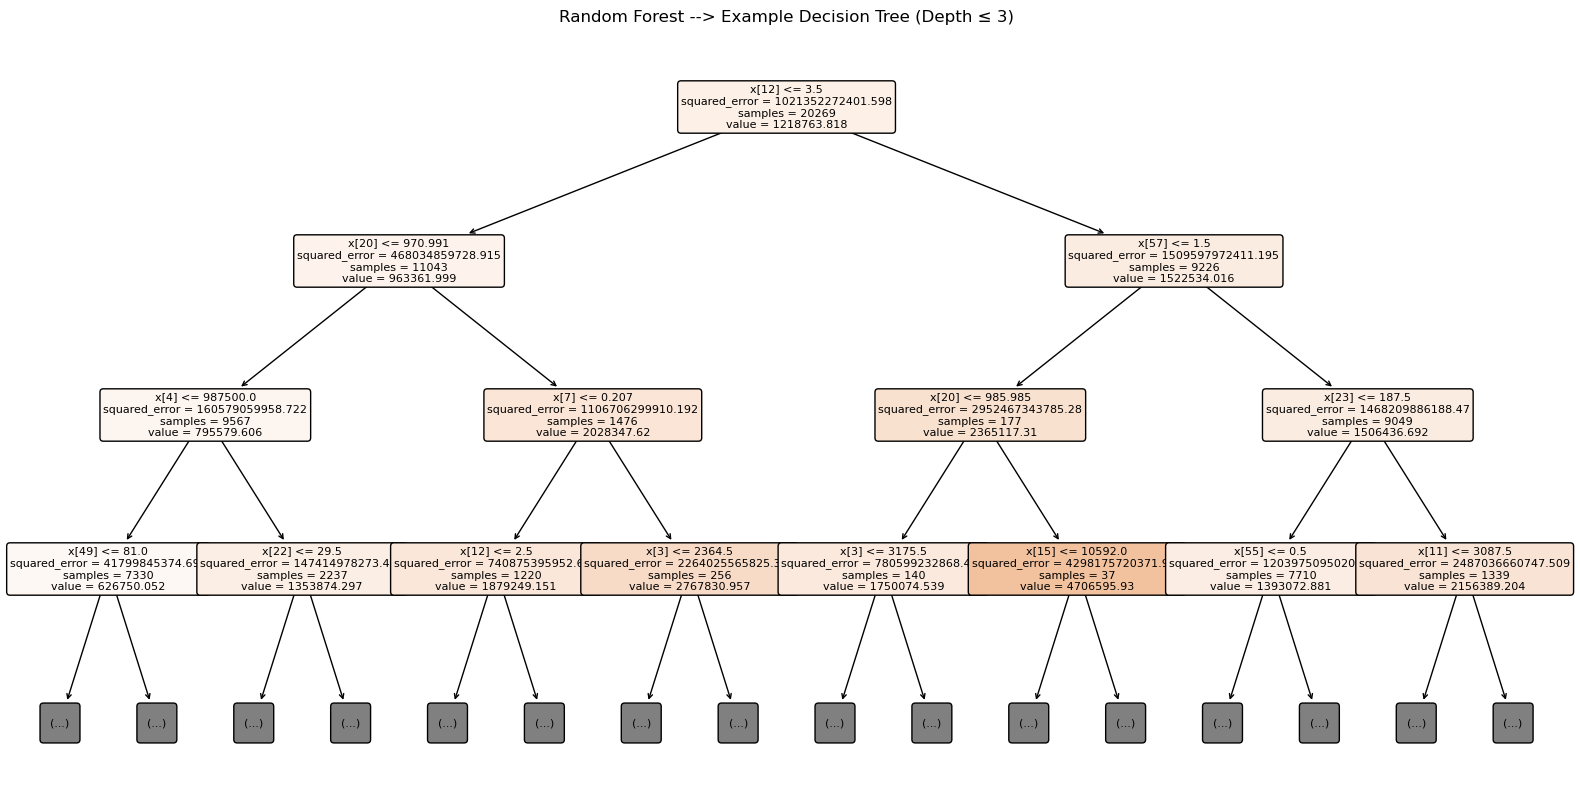

In [29]:
# Visualize one tree using matplotlib 
plt.figure(figsize=(20, 10))
tree.plot_tree(
    rf_model.estimators_[0],
    filled=True,
    rounded=True,
    max_depth=3,   # Keep this small to avoid crash (e.g., 3–4)
    fontsize=8
)
plt.title("Random Forest --> Example Decision Tree (Depth ≤ 3)")
plt.show()

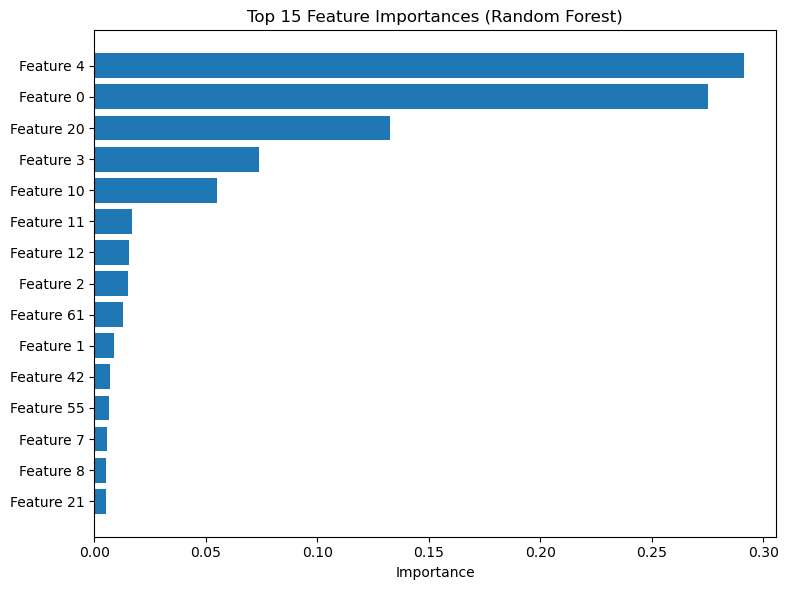

Tree and feature importance visualization completed.


In [30]:
# Feature importance plot
import numpy as np
import pandas as pd

# Compute importances (note: order aligns with preprocessor's numeric + ordinal features)
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_n = 15

plt.figure(figsize=(8, 6))
plt.barh(range(top_n), importances[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), [f"Feature {i}" for i in sorted_idx[:top_n]][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

print("Tree and feature importance visualization completed.")


#### 7. Save Artifacts

In [31]:
models_path = Path("../models")

pd.DataFrame([ridge_m, rf_m]).to_csv(models_path / "baseline_models_results.csv", index=False)
joblib.dump(rf_pipe, models_path / "best_baseline_random_forest.joblib")

with open(models_path / "baseline_models_summary.json", "w") as f:
    json.dump({"ridge": ridge_m, "random_forest": rf_m}, f, indent=2)

print(f"Saved model artifacts → {models_path.resolve()}")

print("\nSaved: models/baseline_models_results.csv, models/best_baseline_random_forest.joblib")

Saved model artifacts → /Users/stephanie/Desktop/Home_Price_Predictions/models

Saved: models/baseline_models_results.csv, models/best_baseline_random_forest.joblib


#### 8. Inference Check

In [32]:
X_sample = X_test.head(5)
print("Predictions sample:", rf_pipe.predict(X_sample))

Predictions sample: [ 344977.0516884  1272013.76612516 1161101.75861615 4959413.67183108
  964182.27756852]
